# OLS Regression Signal Analysis

In the previous notebook the results were generated by manually setting the signal to be long or to be short with respect to finding which direction generates the return. In this case that bias gets relaxed. First begin by analyzing the directionality of the signal via the $\beta$ of the OLS regression

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from PCSpreadOLS import PCASpreadOLS

## Full Sample Results

Originally the signals were set to be short (ie buy when negative and sell when postive) this was just an assumption to "fit" the signal that generates the most returns. First begin with running a full-sample OLS model, and regressing the lagged signal against the return using the $\beta$ as an indicator. 

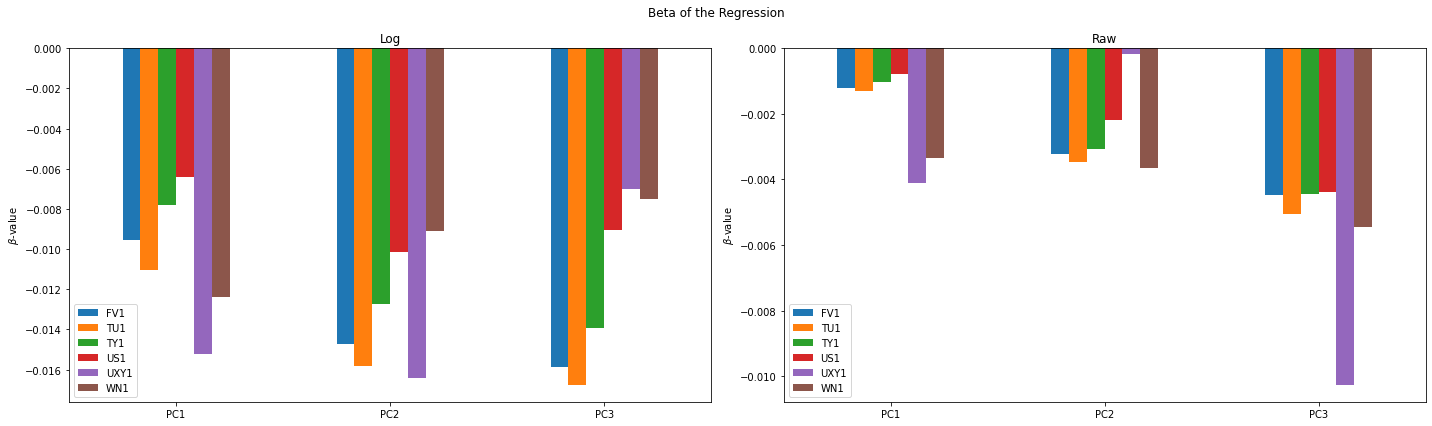

In [3]:
def plot_full_sample_beta() -> plt.Figure: 
    
    df_beta = (PCASpreadOLS().get_signal_ols()[
        ["input_val", "variable", "security", "beta"]].
        drop_duplicates().
        assign(input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize()))

    variables = df_beta.input_val.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_beta.query(
            "input_val == @variable")
            [["variable", "security", "beta"]].
            rename(columns = {"security": ""}).
            pivot(index = "variable", columns = "", values = "beta").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                ylabel = r"$\beta$" + "-value",
                title  = variable))

    fig.suptitle("Beta of the Regression")
    plt.tight_layout()
    
plot_full_sample_beta()

The log signal betas are much stronger than the raw signal beta, further implying the outperformance of the log signal vs. raw signal. 

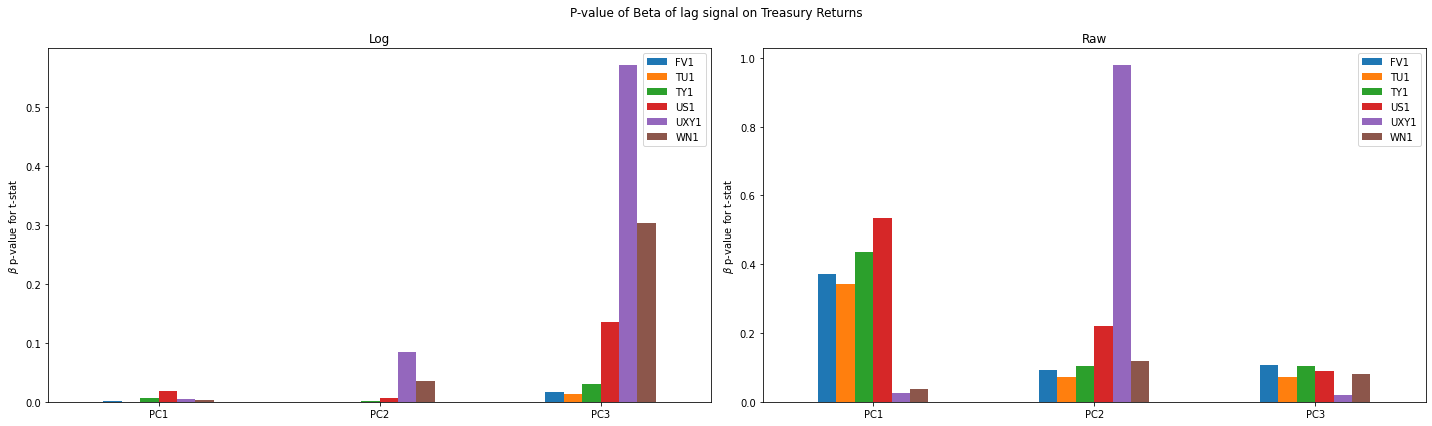

In [4]:
def plot_full_sample_pvalue() -> plt.Figure: 
    
    df_p = (PCASpreadOLS().get_signal_ols()[
        ["input_val", "variable", "security", "p_beta"]].
        drop_duplicates().
        assign(input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize()))

    variables = df_p.input_val.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_p.query(
            "input_val == @variable")
            [["variable", "security", "p_beta"]].
            rename(columns = {"security": ""}).
            pivot(index = "variable", columns = "", values = "p_beta").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                ylabel = r"$\beta$" + " p-value for t-stat",
                title  = variable))
        
    fig.suptitle("P-value of Beta of lag signal on Treasury Returns")
    plt.tight_layout()
    
plot_full_sample_pvalue()

In [5]:
def get_test() -> pd.DataFrame: 
    
    df_test = (PCASpreadOLS().get_signal_ols()[
        ["input_val", "variable", "security", "p_beta"]].
        drop_duplicates().
        assign(pass_test = lambda x: np.where(x.p_beta < 0.05, "pass_test", "fail_test")))
    
    return df_test

df_test = get_test()

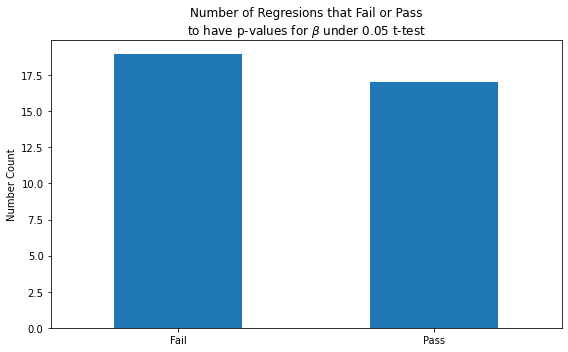

In [6]:
def plot_test(df_test: pd.DataFrame) -> plt.Figure: 
    
    (df_test[
        ["input_val", "pass_test"]].
        groupby("pass_test").
        agg("count").
        reset_index().
        assign(pass_test = lambda x: x.pass_test.str.split("_").str[0].str.capitalize()).
        set_index("pass_test").
        plot(
            figsize = (8,5),
            kind    = "bar",
            rot     = 0,
            legend  = False,
            ylabel  = "Number Count",
            xlabel  = "",
            title   = "Number of Regresions that Fail or Pass\nto have p-values for " + r"$\beta$" + " under 0.05 t-test"))

    plt.tight_layout()
    
plot_test(df_test)

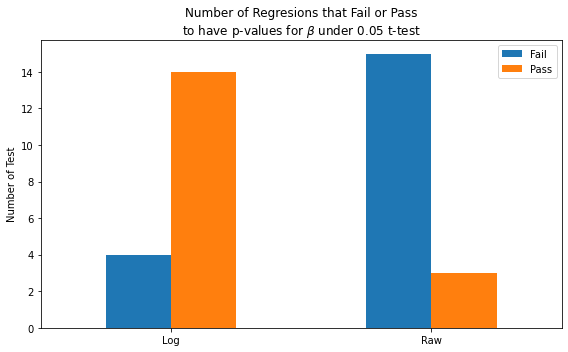

In [7]:
def plot_test_by_input(df_test: pd.DataFrame) -> plt.Figure: 
    
    (df_test[
        ["input_val", "variable", "pass_test"]].
        groupby(["input_val", "pass_test"]).
        agg("count").
        reset_index().
        assign(
            input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize(),
            pass_test = lambda x: x.pass_test.str.split("_").str[0].str.capitalize()).
        rename(columns = {"pass_test": ""}).
        pivot(index = "input_val", columns = "", values = "variable").
        plot(
            kind = "bar",
            ylabel = "Number of Test",
            xlabel = "",
            rot    = 0,
            figsize = (8,5),
            title   = "Number of Regresions that Fail or Pass\nto have p-values for " + r"$\beta$" + " under 0.05 t-test"))
    
    plt.tight_layout()
    
plot_test_by_input(df_test)

Of the $\beta$s that do fail most of them are raw value rather than log value.

Trading the full sample OLS regression is the same as trading the original raw signal. In this case its full sample OLS regression.

In [8]:
def get_signal() -> pd.DataFrame: 
    
    df_signal = (PCASpreadOLS().get_signal_ols().assign(
        signal_bps = lambda x: np.sign(x.beta * x.lag_spread) * x.PX_bps)
        [["date", "input_val", "variable", "security", "signal_bps"]])
    
    return df_signal

df_signal = get_signal()

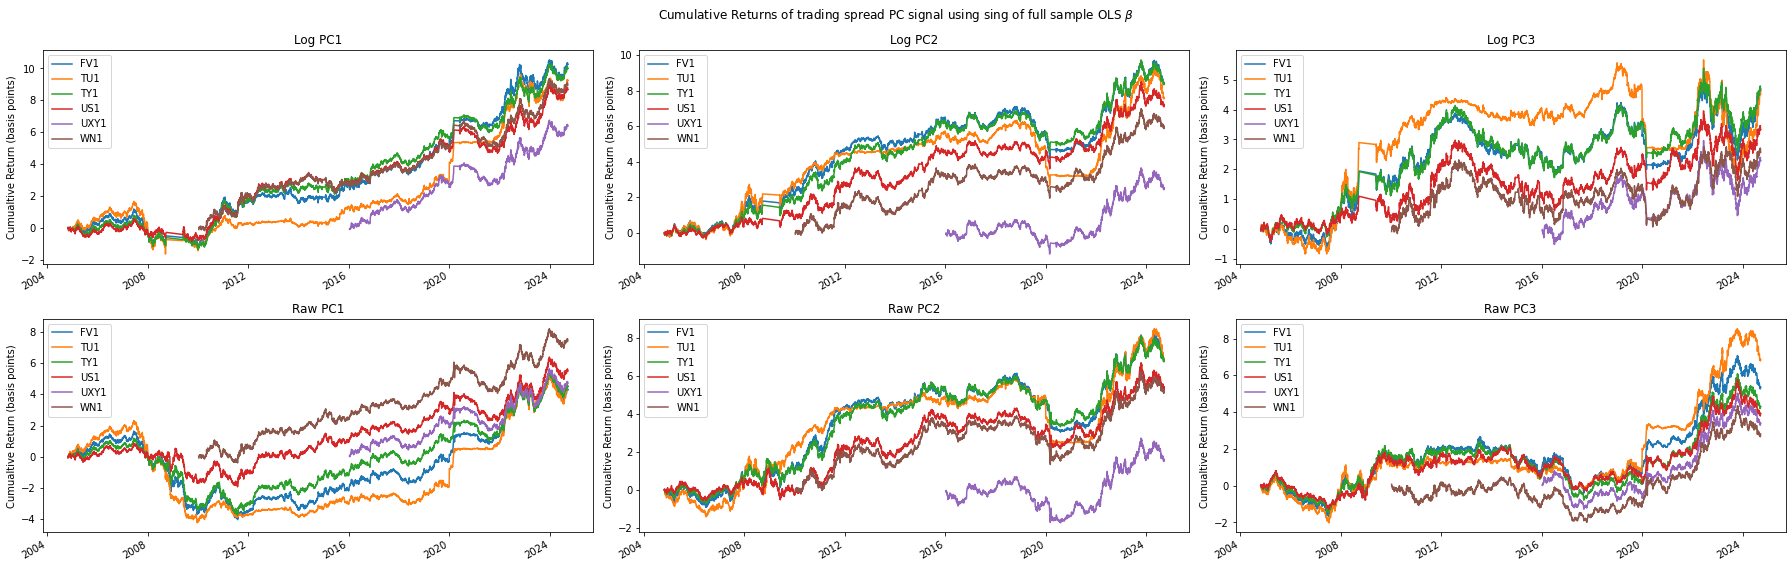

In [9]:
def plot_signal(df_signal: pd.DataFrame) -> plt.Figure:
    
    df_plot = (df_signal.assign(
        group_var = lambda x: x.input_val.str.split("_").str[0].str.capitalize() + " " + x.variable))

    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (25,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var")
            [["date", "security", "signal_bps"]].
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumualtive Return (basis points)",
                xlabel = "",
                title  = group_var))

    fig.suptitle("Cumulative Returns of trading spread PC signal using sing of full sample OLS " + r"$\beta$")
    plt.tight_layout()
    
plot_signal(df_signal)